# Estimate the Moho for South America

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [6]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_assumpcao_moho_points
from moho import MohoGravityInvSpherical, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load the gravity data

Load the data that was processed in [`south-america-gravity-data.ipynb`](south-america-gravity-data.ipynb).

In [8]:
with open('../data/processed-goco5s-data-sam-h50km.txt') as f:
    _ = f.readline()
    line = f.readline()
    full_shape = [int(x) for x in line.split()[1:]]
    full_lat, full_lon, full_height, full_grav = np.loadtxt(f, usecols=[0, 1, 2, -1], unpack=True)
    full_data = [full_lat, full_lon, full_height, full_grav]
print('Number of data points in lat and lon: {}'.format(full_shape))

Number of data points in lat and lon: [401, 301]


This is the full dataset. We'll use a portion of it for the inversion and the rest for [cross-validation](#Cross-validation). 

Make a plot the data.

In [9]:
full_area = (full_lat.min(), full_lat.max(), full_lon.min(), full_lon.max())
bm = Basemap(projection='cyl', 
             llcrnrlon=full_area[2], urcrnrlon=full_area[3], 
             llcrnrlat=full_area[0], urcrnrlat=full_area[1],
             resolution='l')

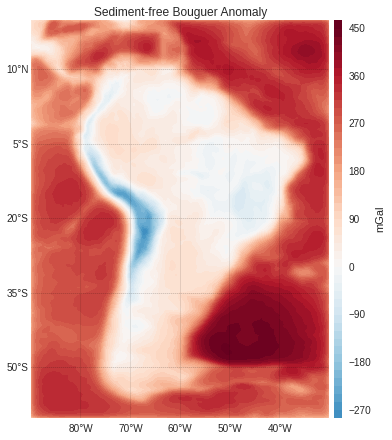

In [10]:
x, y = bm(full_lon, full_lat)
ranges = np.abs([full_grav.min(), full_grav.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly')
bm.contourf(x, y, full_grav, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Cross-validation

We'll split the data into the inversion and test data sets. For the inversion data, we'll take every N grid points. All other points will be used as the test data.

In [11]:
def split_data(data, shape, every):
    data = [i.reshape(shape) for i in data]
    # Take every "every" points for the inversion
    inversion = [i[::every, ::every] for i in data]
    # mask marks the grid points I didn't take for inversion
    mask = np.ones(shape, dtype=np.bool)
    mask[::every, ::every] = False  # These are the ones I took
    test = [i[mask] for i in data]
    shape = inversion[0].shape
    # Sanity checks
    assert all(t.size + i.size == d.size for t, i, d in zip(test, inversion, data)), \
        "Number of points in inversion + test set different from original data."
    assert all(t.size == test[0].size for t in test), "Test set has differet number of points"
    assert all(i.size == inversion[0].size for i in inversion), "Inversion set has differet number of points"
    assert all(i.shape == inversion[0].shape for i in inversion), "Inversion set has differet shape"
    # Print some info
    print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], shape[0]*shape[1]))
    print("Number of test set points: {}".format(test[0].size))
    return [i.ravel() for i in inversion], test, shape

In [12]:
inversion_set, test_set, shape = split_data(full_data, full_shape, every=2)

Number of inversion grid points: 201 x 151 = 30351
Number of test set points: 90350


Plot the inversion data set.

In [13]:
lat, lon, height, data = inversion_set

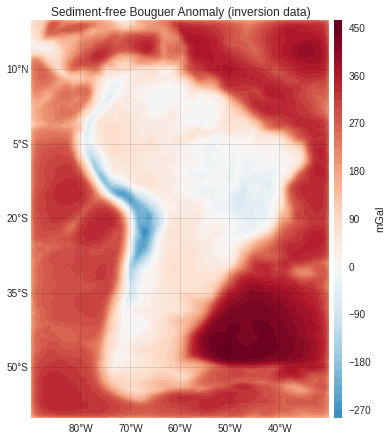

In [14]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly (inversion data)')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

Load the seismic point constraints. This is used in cross-validation to find the reference level and the density contrast.

In [15]:
test_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz', 
                                          todepth=True, return_height=False)[:-1]

The longitude for the seismic points is in the range [-180, 180] but we need it in [0, 360] because of the gravity data.

In [16]:
test_points[1] += 360

Plot the seismic points.

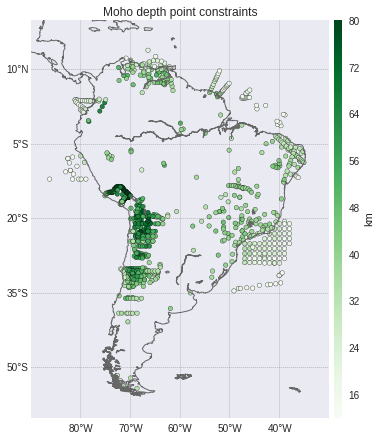

In [17]:
x, y = bm(test_points[1], test_points[0])

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*test_points[-1], s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

Define our cross-validation functions (the same as in [`synthetic-crust1-south-america.ipynb`](synthetic-crust1-south-america.ipynb)).

In [18]:
def score_test_set(model, lat, lon, height, data, njobs=1):
    predicted = tesseroid.gz(lon, lat, height, model, njobs=njobs)
    score = np.sum((predicted - data)**2)/data.size
    return score

In [19]:
def seismic_residuals(moho, lat, lon, height):
    """
    Calculate the residuals between the estimated *moho* (a TesseroidRelief)
    and the point constrains (lat, lon, height).
    
    Values are interpolated onto (lat, lon) for comparison.
    """
    estimated = gridder.interp_at(moho.clat.ravel(), moho.clon.ravel(), moho.relief, 
                                  lat, lon, extrapolate=True)
    return estimated - height
    
def score_seismic_constraints(moho, lat, lon, height):
    """
    Return the MSE between the moho estimate and the point constraints.
    """
    residuals = seismic_residuals(moho, lat, lon, height)
    mse = np.sum(residuals**2)/height.size
    return mse

In [20]:
def fit_all(solvers, njobs=1): 
    """
    Run ``fit`` for all solvers using *njobs* processes.
    """
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_fit, solvers)
        pool.close()
        pool.join()
    else:
        results = map(call_fit, solvers)
    return results

def call_fit(solver):
    """
    Call the ``fit`` method of a solver object.
    If any exceptions arise, returns None.
    """
    try:
        solver.fit()
    except:
        solver = None
    return solver

In [21]:
def score_all(solutions, test_data, points, njobs=1):
    """
    Get the cross-validation score for all solutions using *njobs* processes.
    
    If points is True, will score against the seismic point constraints.
    Otherwise, score against the test dataset.
    """
    args = [[s.estimate_, test_data, points] for s in solutions]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_score, args)
        pool.close()
        pool.join()
    else:
        results = map(call_score, args)
    return np.array(results)

def call_score(args):
    """
    Call score_test_set or score_seismic_constraints on the solution.
    
    Needed because multiprocessing.Pool.map only allows functions with
    a single argument.
    """
    solution, test_data, points = args
    try:
        if points:
            score = score_seismic_constraints(solution, *test_data)
        else:
            score = score_test_set(solution, *test_data)
    except:
        score = np.nan
    return score

## Inversion setup

Create the objects and configuration that we'll need to run the inversions.

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast.

In [22]:
area = (lat.min(), lat.max(), lon.min(), lon.max())
mesh = make_mesh(area, shape)

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [23]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much
config = dict(method='newton', initial=initial, tol=0.2, maxit=6)

## Plotting functions

We'll define some plotting functions here to avoid having all this code down with the results. You can safely skip (not read) this section because we only define the functions here. They are called after the inversion below.

In [24]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*seismic_residuals(moho, *test_points)
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between estimated and seismic (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*seismic_residuals(moho, *test_points)

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, referece_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(-0.001*reference_levels, densities, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(-0.001*referece_levels[best_ref], densities[best_dens], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel('Reference level (km)')
    plt.ylabel(u'Density contrast (kg/m³)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

## Run the inversion and cross-validation

First, define the values of the regularization parameter, reference level, and density that we want to test during cross-validation.

In [25]:
regul_params = np.logspace(-10, -2, 16)
regul_params

array([  1.00000000e-10,   3.41454887e-10,   1.16591440e-09,
         3.98107171e-09,   1.35935639e-08,   4.64158883e-08,
         1.58489319e-07,   5.41169527e-07,   1.84784980e-06,
         6.30957344e-06,   2.15443469e-05,   7.35642254e-05,
         2.51188643e-04,   8.57695899e-04,   2.92864456e-03,
         1.00000000e-02])

In [26]:
reference_levels = np.arange(-40e3, -20e3 + 1, 2500)
reference_levels

array([-40000., -37500., -35000., -32500., -30000., -27500., -25000.,
       -22500., -20000.])

In [27]:
densities = np.arange(200, 500 + 1, 50)
densities

array([200, 250, 300, 350, 400, 450, 500])

First, run the cross-validation to find the regularization parameter. We'll use one of the values for the reference and density contrast. The value of the regularization parameter that we estimate here will be used in the second cross-validation to find the density contrast and reference level.

In [28]:
misfit.set_density(densities[-1]).set_reference(reference_levels[-1])

Run the inversion for each value in `regul_params` (in parallel using all available cores). 

In [29]:
%time solutions_regul = fit_all([(misfit + mu*regul).config(**config) for mu in regul_params], njobs=ncpu)

CPU times: user 22.8 s, sys: 4.63 s, total: 27.4 s
Wall time: 7h 15min 20s


In [30]:
with open('south-america-moho.regul.pickle', 'w') as f:
    pickle.dump([solutions_regul], f)

Score the results against the test dataset.

In [31]:
%time scores_regul = score_all(solutions_regul, test_set, points=False, njobs=ncpu)

CPU times: user 9.67 s, sys: 2.08 s, total: 11.7 s
Wall time: 3h 1min 1s


In [32]:
with open('south-america-moho.regul_scores.pickle', 'w') as f:
    pickle.dump([scores_regul], f)

The best solution is the one with the smallest cross-validation score.

In [33]:
best_regul = np.argmin(scores_regul)

We'll use this solution as the inversion solver for the next cross-validation (for the reference level and density).

In [34]:
solver = solutions_regul[best_regul]

Take a look at the current solution. Plot the cross-validation scores, the inversion residuals, and the estimated solution.

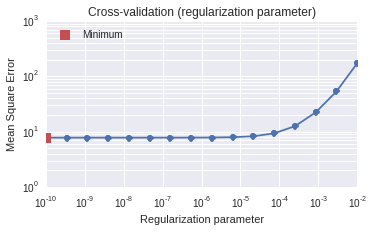

In [35]:
plot_cv_regul(regul_params, scores_regul, best_regul, log=True)
plt.grid(True, which='both', axis='y')

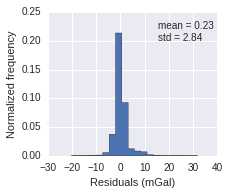

In [36]:
plot_residuals(solver)

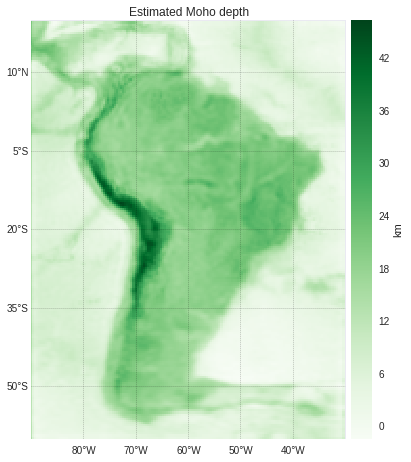

In [37]:
plot_estimate(solver, bm)

Run the second cross-validation to estimate the density-contrast and the reference level.

In [38]:
def set_ref_dens(solver, ref, dens):
    """
    Configure the solver to use this reference level and density.
    """
    res = solver.copy(deep=True)
    res[0].set_density(dens).set_reference(ref)
    return res

In [39]:
solvers = [set_ref_dens(solver, ref, dens) for dens in densities for ref in reference_levels]
%time solutions_refdens = fit_all(solvers, njobs=ncpu)

CPU times: user 1min 26s, sys: 19.7 s, total: 1min 45s
Wall time: 1d 4h 7min 23s


[Pickle](https://docs.python.org/2/library/pickle.html) the results for later.

In [40]:
with open('south-america-moho.pickle', 'w') as f:
    pickle.dump([solutions_regul, scores_regul, solutions_refdens], f)

Uncomment the cell below to load the solutions from the pickle file.

In [41]:
#with open('south-america-moho.pickle') as f:
#    solutions_regul, scores_regul, solutions_refdens = pickle.load(f)

Score the estimates against the seismic constraints.

In [42]:
# Reshape the scores array because it should be a matrix 
# with density as the rows and reference level as the columns.
# This will make it easier for us to find the best density and reference level below.
scores_refdens = score_all(solutions_refdens, test_points, points=True).reshape((len(densities), len(reference_levels)))

In [43]:
best = np.nanargmin(scores_refdens)
solution = solutions_refdens[best]
# Find the index in reference_levels and densities corresponding to best
best_dens, best_ref = np.unravel_index(best, scores_refdens.shape)

Print the estimated parameters:

In [44]:
print('Cross-validation results:')
print(u'  reference level: {} km'.format(-0.001*reference_levels[best_ref]))
print(u'  density contrast: {} kg/m³'.format(densities[best_dens]))
print(u'  regularization parameter: {}'.format(regul_params[best_regul]))

Cross-validation results:
  reference level: 35.0 km
  density contrast: 400 kg/m³
  regularization parameter: 1e-10


Make plots of the second cross-validation and the estimated Moho.

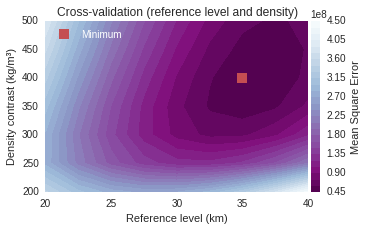

In [45]:
plot_cv_ref_dens(densities, reference_levels, scores_refdens, best_dens, best_ref)

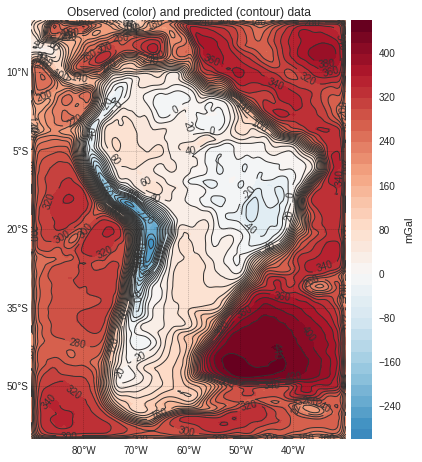

In [46]:
plot_fit(lat, lon, data, solution, bm)

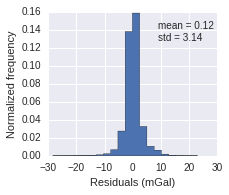

In [47]:
plot_residuals(solution)

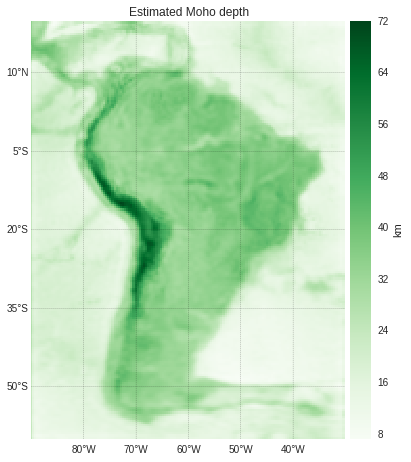

In [48]:
plot_estimate(solution, bm)

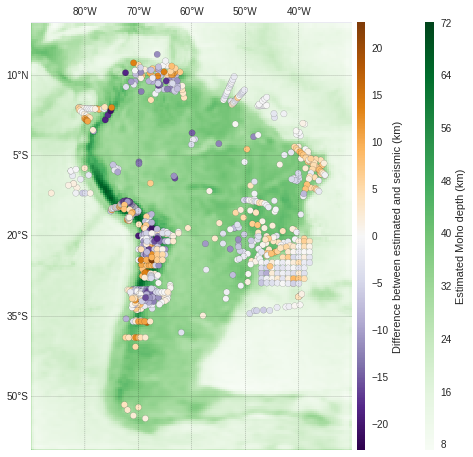

In [49]:
plot_diff_seismic(solution, test_points, bm)

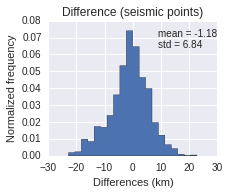

In [50]:
plot_diff_seismic_hist(solution, test_points)

[]()